### ToDO

- Export to gephi or similar tool to rearrange

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ethograph.utils.io import TrialTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ethograph.utils.labels import load_motif_mapping
from ethograph.utils.data_utils import ds_to_df


paths = [r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250526_01\behav\trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_02\behav\trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\trial_data.nc"]



merge_dict = {}

for i, path in enumerate(paths):
    print(path)
    dt_temp = TrialTree.load(path)
    
    merge_dict[f"session_{i}"] = dt_temp


dt = TrialTree.merge_session_trees(merge_dict)
ds = dt.stack_session(
    concat_dim="trials",
    keep_vars=["labels"],
    attrs_to_vars=["poscat", "num_pellets"]
)
df = ds_to_df(ds)

C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250526_01\behav\trial_data.nc
C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\trial_data.nc
C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_02\behav\trial_data.nc
C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\trial_data.nc


In [40]:
import pandas as pd
import numpy as np
from collections import Counter
from typing import Dict, Optional
from pathlib import Path


def df_to_graphviz(df: pd.DataFrame, output_file: str = "transitions.dot",
                   motif_mapping: Optional[Dict[int, Dict]] = None,
                   ignore_state: int = 0, layout: str = "circo",
                   min_prob: float = 0.2) -> str:
    """
    Convert DataFrame sequences to Graphviz DOT format with probability filtering.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'sequence' and optional 'count' columns
    output_file : str
        Output filename for DOT file
    motif_mapping : Dict
        Mapping of states to names and colors
    ignore_state : int
        State to ignore (default: 0)
    layout : str
        Graphviz layout engine (circo for circular, dot for hierarchical)
    min_prob : float
        Minimum probability threshold for all transitions (default: 0.2)
    
    Returns
    -------
    str : DOT format string
    """
    sequences = df['sequence'].tolist()
    weights = df['count'].tolist() if 'count' in df else [1] * len(sequences)
    
    transition_counts = Counter()
    state_frequencies = Counter()
    outgoing_counts = Counter()
    
    for seq, weight in zip(sequences, weights):
        for state in seq:
            if state != ignore_state:
                state_frequencies[state] += weight
        
        prev = None
        for state in seq:
            if state != ignore_state:
                if prev is not None:
                    transition_counts[(prev, state)] += weight
                    outgoing_counts[prev] += weight
                prev = state
            else:
                prev = None
    
    transition_probs = {
        (src, tgt): count / outgoing_counts[src]
        for (src, tgt), count in transition_counts.items()
    }
    
    filtered_transitions = {
        (src, tgt): prob
        for (src, tgt), prob in transition_probs.items()
        if prob >= min_prob
    }
    
    states_in_transitions = set()
    for src, tgt in filtered_transitions.keys():
        states_in_transitions.update([src, tgt])
    
    state_frequencies = {k: v for k, v in state_frequencies.items() 
                       if k in states_in_transitions}
    
    dot_lines = ['digraph StateTransitions {', '    // Graph settings',
                 '    rankdir=LR;', f'    layout={layout};', '    overlap=false;',
                 '    splines=curved;', '    bgcolor="white";',
                 '    node [shape=circle, style=filled, fontsize=16, fontweight=bold, '
                 'width=0.8, height=0.8, fixedsize=true];',
                 '    edge [fontsize=12, fontweight=bold];', '',
                 '    // Nodes with colors and labels']
    
    for state in sorted(state_frequencies.keys()):
        label = str(state)
        if motif_mapping and state in motif_mapping:
            name = motif_mapping[state]['name']
            color = motif_mapping[state]['color']
            if hasattr(color, '__iter__'):
                hex_color = '#{:02x}{:02x}{:02x}'.format(
                    int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
            else:
                hex_color = '#808080'
            
            text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
            dot_lines.append(f'    {state} [label="{label}", fillcolor="{hex_color}", '
                           f'fontcolor="{text_color}", tooltip="{name}"];')
        else:
            dot_lines.append(f'    {state} [label="{label}", fillcolor="#87CEEB"];')
    
    dot_lines.extend(['', '    // Edges with probabilities'])
    
    if filtered_transitions:
        max_prob = max(filtered_transitions.values())
        for (src, tgt), prob in sorted(filtered_transitions.items()):
            penwidth = 1 + (prob / max_prob) * 5
            dot_lines.append(f'    {src} -> {tgt} [label=" {prob:.2f} ", penwidth={penwidth:.1f}, '
                           f'color="gray40", fontcolor="black"];')
    
    dot_lines.append('}')
    dot_content = '\n'.join(dot_lines)
    
    with open(output_file, 'w') as f:
        f.write(dot_content)
    
    print(f"✅ DOT file created: {output_file}")
    if filtered_transitions and transition_probs:
        print(f"Filtered out transitions below {min_prob}")
        print(f"Showing {len(filtered_transitions)} of {len(transition_probs)} transitions")
    print(f"To render: dot -Tpng {output_file} -o transitions.png")
    print(f"Or try: circo -Tpng {output_file} -o transitions_circular.png")
    
    return dot_content


def visualize_with_python(dot_file: str):
    """Render and display using Python graphviz package"""
    from graphviz import Source
    
    with open(dot_file, 'r') as f:
        dot_content = f.read()
    
    graph = Source(dot_content)
    graph.render('transitions', format='png')
    graph.render('transitions', format='svg')
    
    print("✅ Graph rendered and opened!")
    return graph

✅ DOT file created: my_transitions.dot
Filtered out transitions below 0.15
Showing 23 of 53 transitions
To render: dot -Tpng my_transitions.dot -o transitions.png
Or try: circo -Tpng my_transitions.dot -o transitions_circular.png
✅ Graph rendered and opened!


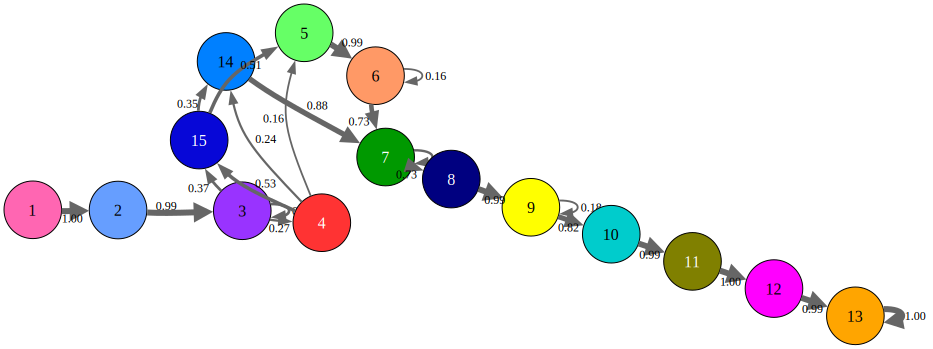

In [41]:

motif_mapping = load_motif_mapping(r"C:\Users\Admin\Documents\Akseli\Code\MovFormer\configs_global\mapping.txt")

dot_content = df_to_graphviz(
    df=df,
    output_file='my_transitions.dot',
    motif_mapping=motif_mapping,
    ignore_state=0,  # Ignore state 0 (background)
    layout='circo',  # Circular layout
    min_prob=0.15  # Filter bottom 20%
)
# Optional: Render with Python graphviz package
visualize_with_python('my_transitions.dot')

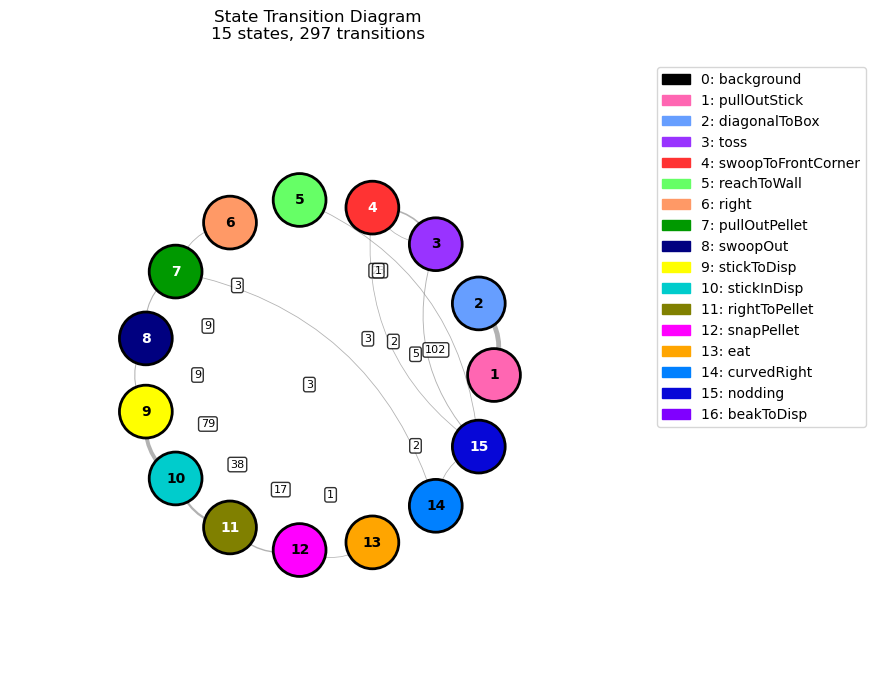

In [ ]:
path = r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc"

import xarray as xr
from ethograph.utils.io import TrialTree
from ethograph.diffact.eval import load_mapping

dt = xr.open_datatree(path)
dt = TrialTree(dt)

labels_list = []
for trial in dt.trials:
    labels_list.append(dt.sel(trials=trial, individuals="Freddy").labels.values)

# No longer need the old class_mapping since we're using load_motif_mapping
# _, class_mapping = load_mapping(r"D:\Akseli\Code\MovFormer\mapping.txt")



# Now the function uses load_motif_mapping internally and displays class IDs
fig, ax = plt.subplots(figsize=(8,8))
create_circular_diagram_with_labels(ax, labels_list, motif_mappings=motif_mapping, node_size = 0.06)
ax.set_xlim(-0.7, 0.7)
ax.set_ylim(-0.7, 0.7)
ax.set_aspect('equal')
ax.axis('off')


In [ ]:
feat_ds = ds.sel(**feat_kwargs).squeeze().filter_by_attrs(type="features")
features = feat_ds.to_stacked_array('features', sample_dims=['time']).values # flatten across non-time dimensions

nan_rows = np.where(np.all(np.isnan(features), axis=0))[0]
nan_rows

array([18, 19])

In [ ]:
print(labels_list[:2])

[array([0., 0., 0., ..., 0., 0., 0.], shape=(1908,)), array([0., 0., 0., ..., 0., 0., 0.], shape=(1081,))]


In [ ]:
import matplotlib.pyplot as plt
from netgraph import Graph
from collections import Counter

def create_transition_diagram(sequence: str, ignore_state: str = '0'):
    """Create professional transition diagram with auto-layout."""
    # Extract transitions
    transitions = []
    prev = None
    for state in sequence:
        if state != ignore_state:
            if prev and prev != state:
                transitions.append((prev, state))
            prev = state
        else:
            prev = None
    
    # Count transitions and self-loops
    edge_counts = Counter(transitions)
    
    # Find self-loops (if any)
    for state in set(s for s in sequence if s != ignore_state):
        if sequence.count(state * 2) > 0:  # Check for repeated states
            count = len([i for i in range(len(sequence)-1) 
                        if sequence[i] == sequence[i+1] == state])
            if count > 0:
                edge_counts[(state, state)] = count
    
    # Prepare graph data
    edges = list(edge_counts.keys())
    weights = list(edge_counts.values())
    max_weight = max(weights) if weights else 1
    
    # Scale edge widths
    edge_width = {e: 0.5 + (w/max_weight)*4 for e, w in edge_counts.items()}
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the graph
    g = Graph(
        edges,
        edge_width=edge_width,
        edge_label=edge_counts,
        edge_label_fontdict=dict(size=12, weight='bold'),
        node_layout='spring',
        node_size=10,
        node_color='lightblue',
        node_edge_color='black',
        node_edge_width=2,
        node_label_fontdict=dict(size=16, weight='bold'),
        edge_color='black',
        edge_arrow_size=15,
        edge_layout='curved',
        edge_layout_kwargs=dict(k=0.15),
        ax=ax
    )
    
    ax.set_title("Transition Diagram", fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage
sequence = "00001111110000022220000333300002222"
fig = create_transition_diagram(sequence)